In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))

# create connection
conn = create_engine('sqlite:///inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## transit boarding

### boarding by agency

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [3]:
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df.sum(axis=0).observed_boardings
table_df.loc['Total','model_boardings'] = table_df.sum(axis=0).model_boardings
table_df.loc['Total','agency'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

,index,agency,observed_boardings,model_boardings,diff,perc_diff
0,2,King County Metro,"253,313.62","326,219.59","72,905.97",28.78%
1,5,Sound Transit,"113,374.00","121,422.34","8,048.34",7.10%
2,0,Community Transit,"25,962.00","20,987.26","-4,974.74",-19.16%
3,4,Pierce Transit,"21,185.00","16,510.58","-4,674.42",-22.06%
4,6,Washington Ferries,"9,278.21","3,692.22","-5,585.99",-60.21%
5,3,Kitsap Transit,"7,789.00","16,231.98","8,442.98",108.40%
6,1,Everett Transit,"4,201.00","2,830.14","-1,370.86",-32.63%
7,Total,Total,"435,102.83","507,894.11","72,791.29",16.73%


In [4]:
# fig = px.bar(plot_df.sort_values('source'), x="agency", y="count",
#              color="source", barmode="group",
#              title="transit boardings by agency")
# fig.update_layout(height=400, width=700, font=dict(size=11),
#                   yaxis_tickformat = '.2f')
# fig.show()

### boarding by key route

In [6]:
df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')

df = df_boarding_key[df_boarding_key['route_code'].isin([4200,4201,4203,4204,5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,973 W Sea Water Taxi,759.00,313.73,-445.27,-58.66%
1,975 Vashn Water Taxi,338.00,463.10,125.10,37.01%
2,Seattle-Bremerton FF,"1,913.00","6,125.12","4,212.12",220.18%
3,Brem-Pt Orchard FF,768.00,"1,095.51",327.51,42.65%
4,Brem-Annapolis FF,429.00,390.22,-38.78,-9.04%
5,Seattle-Southwrth FF,631.00,833.44,202.44,32.08%
6,WSF Edmonds-Kingston,"1,500.13",51.11,"-1,449.03",-96.59%
7,WSF Seattle-Bain Isl,"5,513.69","1,810.26","-3,703.43",-67.17%
8,WSF Seattle-Brem,"1,188.97",301.42,-887.55,-74.65%
9,WSF Fauntleroy-Swrth,142.56,412.01,269.45,189.01%


r^2 : 0.8505889796164132


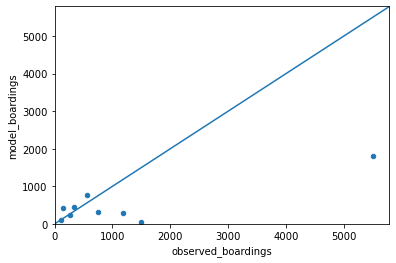

In [6]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

##### bikes on ferry

In [7]:
df = pd.read_csv(os.path.join(csv_path,'bike_ferry_boardings.csv')).sort_values('@bvol', ascending=False)
df['route_code'] = df['route_code'].astype('int')
df[['route_code','description', '@bvol']]

,route_code,description,@bvol
4,4203,Brem-Annapolis FF,644.30
2,4200,Seattle-Bremerton FF,404.70
0,1973,973 W Sea Water Taxi,366.20
3,4201,Brem-Pt Orchard FF,333.50
1,1975,975 Vashn Water Taxi,183.20
11,5007,WSF Pt Def-Tahlequah,128.00
10,5005,WSF Fauntleroy-Vashn,125.10
9,5004,WSF Fauntleroy-Swrth,55.10
8,5003,WSF Seattle-Brem,22.00
7,5002,WSF Seattle-Bain Isl,20.00


In [8]:
df = df_boarding_key[df_boarding_key['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)

df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,Link Red Line,"79,522.00","60,341.95","-19,180.05",-24.12%
1,Sounder South,"6,038.00","7,062.96","1,024.96",16.98%
2,Sounder North,316.00,2.73,-313.27,-99.14%


r^2 : 0.9991012583797654


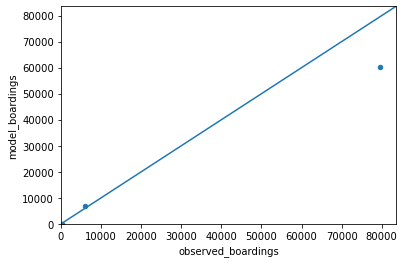

In [9]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [10]:
df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('model_boardings', ascending=False)

,description,observed_boardings,model_boardings,diff,perc_diff
6,E Line RapidRide,"11,426.00","19,082.09","7,656.09",67.01%
4,C Line RapidRide,"7,250.00","12,266.71","5,016.71",69.20%
1,KC Metro 40,"7,208.00","11,440.39","4,232.39",58.72%
0,KC Metro 7,"9,954.00","10,592.84",638.84,6.42%
5,D Line RapidRide,"9,044.00","9,512.50",468.50,5.18%
10,Sound Transit 550,"3,351.00","9,205.47","5,854.47",174.71%
2,A Line RapidRide,"8,412.00","7,425.05",-986.95,-11.73%
7,F Line RapidRide,"4,748.00","6,561.28","1,813.28",38.19%
3,B Line RapidRide,"4,177.00","4,634.66",457.66,10.96%
9,First Hill Streetcar,"3,900.45","1,215.53","-2,684.93",-68.84%


r^2 : 0.8115950809620033


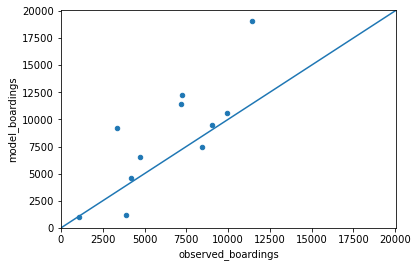

In [11]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
    ax.set_ylim(0, lim)
    ax.set_xlim(0, lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

### boarding on lines by agency

r^2 Community Transit: 0.9435382032839669
r^2 Everett Transit: 0.9695907315740929
r^2 King County Metro: 0.920909446238542
r^2 Kitsap Transit: 0.9378658697607695
r^2 Pierce Transit: 0.7055478124869974
r^2 Sound Transit: 0.9878909054789891
r^2 Washington Ferries: 0.8586819050256671


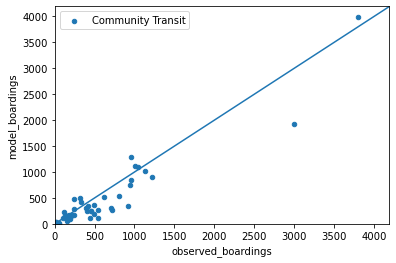

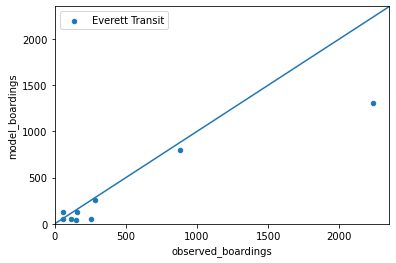

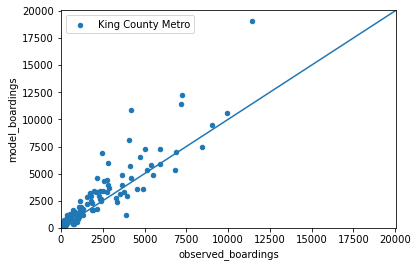

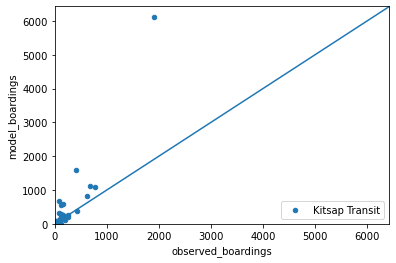

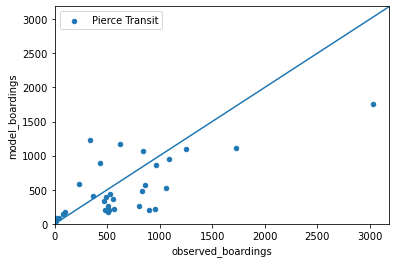

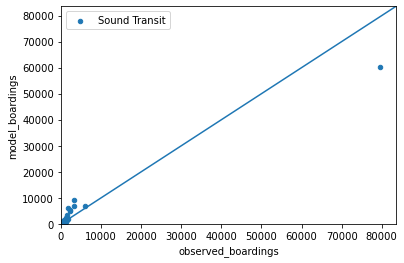

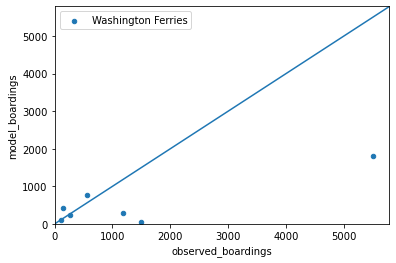

In [12]:
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [13]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Husky Stadium,"6,134.00","3,340.08","-2,793.92",-45.55%
Westlake,"8,845.00","6,770.45","-2,074.55",-23.45%
University St,"4,324.00","4,134.77",-189.23,-4.38%
Pioneer Square,"2,400.00","4,247.87","1,847.87",76.99%
Int'l District,"4,399.00","1,412.79","-2,986.21",-67.88%
Capitol Hill,"7,667.00","4,921.26","-2,745.74",-35.81%
Stadium,"1,731.00",488.51,"-1,242.49",-71.78%
SODO,"1,669.00","2,452.91",783.91,46.97%
Beacon Hill,"2,147.00",894.39,"-1,252.61",-58.34%


In [14]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/University St'
df_combined.loc[['University St'],'station_group'] = 'Westlake/University St'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined.loc[['Husky Stadium','Capitol Hill','Westlake/University St',"Pioneer Square/Int'l District",
                 'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                 "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]

,observed_boardings,model_boardings,diff,percent_diff
station_group,,,,
Husky Stadium,"6,134.00","3,340.08","-2,793.92",-45.55%
Capitol Hill,"7,667.00","4,921.26","-2,745.74",-35.81%
Westlake/University St,"13,169.00","10,905.22","-2,263.78",-17.19%
Pioneer Square/Int'l District,"6,799.00","5,660.66","-1,138.34",-16.74%
Stadium/SODO,"3,400.00","2,941.42",-458.58,-13.49%
Beacon Hill/Mount Baker,"4,008.00","1,891.90","-2,116.10",-52.80%
Columbia City,"1,630.00",992.77,-637.23,-39.09%
Othello/Rainier Beach,"3,525.00","2,317.61","-1,207.39",-34.25%
Tukwila Int'l Blvd,"2,298.00","1,714.00",-584.00,-25.41%


### light rail stop transfers

In [15]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,modeled_transfer_rate,observed_transfer_rate,diff,percent_diff
station_name,,,,
Husky Stadium,0.90,-99.00,99.90,-100.91%
Westlake,0.16,0.36,-0.20,-55.31%
University St,0.26,0.20,0.06,28.46%
Pioneer Square,0.50,0.16,0.34,216.97%
Int'l District,0.68,0.45,0.23,50.23%
Capitol Hill,0.06,-99.00,99.06,-100.06%
Stadium,0.20,0.12,0.08,68.58%
SODO,0.45,0.31,0.14,43.65%
Beacon Hill,0.39,0.35,0.04,11.04%
